In [ ]:
from keras.models import Sequential,Model
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers import Conv2D, MaxPooling2D,Input,Concatenate,AveragePooling2D,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential,Model
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers import Conv2D, MaxPooling2D,Input
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD,Adam

In [27]:
base_model=VGG16(input_shape=(224,224,3),include_top=False)
base_model.trainable=False

x=Flatten()(base_model.output)

x=Flatten()(base_model.output)
x=Dense(9200,activation='relu')(x)
x=Dense(9100,activation='relu')(x)


out=Dense(3,activation='softmax')(x)
model=Model(inputs=base_model.inputs,outputs=out)

model.summary()
print(len(model.layers))
for layer in model.layers:
  print(layer.name," ",layer.trainable)

for layer in model.layers[:10]:
  layer.trainable=False

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [28]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
trainPath="./drive/MyDrive/drn_lrn_fnl/chest_xray/train/"
testPath="./drive/MyDrive/drn_lrn_fnl/chest_xray/test/"

trainDataGen=ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.35,
)

testDataGen=ImageDataGenerator(rescale=1./255)

trainGen=trainDataGen.flow_from_directory(
    trainPath,
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=128,
    subset='training',
    shuffle=True
)

valGen=trainDataGen.flow_from_directory(
    trainPath,
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=128,
    subset='validation',
    shuffle=True
)

testGen=testDataGen.flow_from_directory(
    testPath,
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=1
)

Found 4543 images belonging to 3 classes.
Found 503 images belonging to 3 classes.
Found 624 images belonging to 3 classes.


In [31]:

from keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks=[EarlyStopping(monitor='val_loss',patience=5), ModelCheckpoint(filepath="beset_model.h5",monitor='val_loss',save_best_only=True)]

opt = SGD(learning_rate=0.00003,momentum=0.10)
model.compile(loss="categorical_crossentropy",optimizer=opt,metrics=["accuracy"])

history=model.fit(
    trainGen,
    steps_per_epoch=trainGen.samples//128,
    validation_data=valGen,
    epochs=50,
    validation_steps=valGen.samples//128,
    callbacks = callbacks
)

Epoch 1/50
35/35 [==============================] - 132s 4s/step - loss: 1.0685 - accuracy: 0.4631 - val_loss: 1.0461 - val_accuracy: 0.4635
Epoch 2/50
35/35 [==============================] - 129s 4s/step - loss: 1.0381 - accuracy: 0.4742 - val_loss: 1.0089 - val_accuracy: 0.5026
Epoch 3/50
35/35 [==============================] - 134s 4s/step - loss: 1.0381 - accuracy: 0.4624 - val_loss: 1.0177 - val_accuracy: 0.4635
Epoch 4/50
35/35 [==============================] - 126s 4s/step - loss: 1.0285 - accuracy: 0.4616 - val_loss: 1.0075 - val_accuracy: 0.4740
Epoch 5/50
35/35 [==============================] - 133s 4s/step - loss: 1.0240 - accuracy: 0.4584 - val_loss: 1.0035 - val_accuracy: 0.4688
Epoch 6/50
35/35 [==============================] - 135s 4s/step - loss: 1.0065 - accuracy: 0.4758 - val_loss: 0.9953 - val_accuracy: 0.4818
Epoch 7/50
35/35 [==============================] - 139s 4s/step - loss: 0.9956 - accuracy: 0.4943 - val_loss: 0.9871 - val_accuracy: 0.4740
Epoch 8/50
35

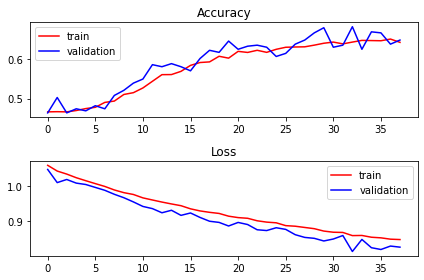

In [32]:
import matplotlib.pyplot as plt

plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["accuracy"],color='r',label='train')
plt.plot(history.history["val_accuracy"],color='b',label='validation')
plt.legend(loc='best')

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"],color='r',label='train')
plt.plot(history.history["val_loss"],color='b',label='validation')
plt.legend(loc='best')


plt.tight_layout()
plt.show()


In [35]:
import numpy as np
pred = model.predict(testGen, steps=testGen.samples//1)
pred_cls = np.argmax(pred, axis=1)

tr_cls = testGen.classes
cls_lbl = list(testGen.class_indices.keys())


from sklearn.metrics import confusion_matrix, classification_report

print('Confusion Matrisi')
con_mx=confusion_matrix(tr_cls,pred_cls)
print(con_mx,"\n")

print('Classification Bilgisi')
print(classification_report(tr_cls, pred_cls))

Confusion Matrisi
[[ 99 134   1]
 [ 73 168   1]
 [ 55  91   2]] 

Classification Bilgisi
              precision    recall  f1-score   support

           0       0.44      0.42      0.43       234
           1       0.43      0.69      0.53       242
           2       0.50      0.01      0.03       148

    accuracy                           0.43       624
   macro avg       0.45      0.38      0.33       624
weighted avg       0.45      0.43      0.37       624

